## 📘 Overview

This document explains the logic and methodology behind our DeFi credit scoring model that assigns scores between 0–1000 to wallet addresses based on their transaction behavior on the Aave V2 protocol.


### Basic Imports

In [40]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [41]:
df = pd.read_json("data/cleaned_wallet_data.json", lines=True)
df.head()

,_id,userWallet,timestamp,blockNumber,action,type,amount,assetSymbol,assetPriceUSD,poolId,userId,date,is_liquidated
0,681d38fed63812d4655f571a,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17 05:29:26,1629178166,deposit,Deposit,2000000000,USDC,0.993832,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17,False
1,681aa70dd6df53021cc6f3c0,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20 15:36:53,1621525013,deposit,Deposit,-9223372036854775808,WMATIC,1.970307,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20,False
2,681d04c2d63812d4654c733e,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24 09:28:33,1627118913,deposit,Deposit,1000000000000000,WMATIC,0.922377,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24,False
3,681d133bd63812d46551b6ef,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-31 23:15:18,1627773318,deposit,Deposit,4000000000000000,WMATIC,1.057483,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-31,False
4,681899e4ba49fc91cf2f4454,0x0000000000e189dd664b9ab08a33c4839953852c,2021-04-19 15:25:07,1618845907,redeemunderlying,RedeemUnderlying,501548,USDC,1.002130,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x7f90122bf0700f9e7e1f688fe926940e8839f353,2021-04-19,False


In [42]:
df.columns

Index(['_id', 'userWallet', 'timestamp', 'blockNumber', 'action', 'type',
       'amount', 'assetSymbol', 'assetPriceUSD', 'poolId', 'userId', 'date',
       'is_liquidated'],
      dtype='object')

## Feature Engineering Overview

In this step, we aggregate transaction-level data into wallet-level features that capture users’ behavioral patterns, risk indicators, and stability signals. The resulting feature table will have one row per wallet and the following columns:

| Column Name            | Description                                                                                     |
|------------------------|-------------------------------------------------------------------------------------------------|
| **userWallet**         | Unique identifier for each wallet                                                              |
| **total_txns**         | Total number of transactions performed by the wallet                                            |
| **days_active**        | Number of days between the first and last transaction (inclusive)                               |
| **txns_per_day**       | Average number of transactions per day (`total_txns / days_active`)                             |
| **avg_time_bw_txn**    | Mean time (in seconds) between consecutive transactions                                         |
| **std_time_bw_txn**    | Standard deviation of time (in seconds) between transactions                                    |
| **(action types)**     | Proportion of each action (`deposit`, `borrow`, `repay`, `redeemunderlying`, `liquidationcall`)|
| **num_liquidations**   | Total count of liquidation events                                                               |
| **liq_ratio**          | Ratio of liquidations to total transactions                                                     |
| **repay_freq**         | Fraction of transactions that are repayments                                                    |
| **borrow_deposit_ratio**| Total borrowed amount divided by total deposited amount                                         |
| **unique_assets**      | Count of distinct asset symbols transacted                                                      |
| **max_asset_share**    | Highest share of transactions for a single asset (`most frequent asset count / total_txns`)    |

**Logic Summary:**
1. **Behavioral Patterns:**
   - **Frequency & Regularity:** Compute total transactions, days active, and transactions per day.
   - **Inter-transaction Timing:** Calculate mean and variability of time gaps between transactions.
   - **Action Mix:** Measure the distribution of different DeFi actions to capture user behavior.

2. **Risk Indicators:**
   - **Liquidation History:** Count and normalize liquidations to flag risky positions.
   - **Repayment Behavior:** Derive repayment frequency as a measure of on-time loan settlement.
   - **Utilization Metrics:** Evaluate borrowing vs. depositing to understand leverage usage.

3. **Stability Signals:**
   - **Account Tenure:** Track the active duration of each wallet.
   - **Asset Diversification:** Assess number of distinct assets and concentration risk.

This feature table provides a robust foundation for downstream modeling, balancing interpretability with coverage of key DeFi risk factors.


In [56]:
if 'isliquidated' not in df.columns:
    df['isliquidated'] = False


wallet_groups = df.groupby('userWallet')


wf = pd.DataFrame(index=wallet_groups.size().index)

dates = wallet_groups['date']
wf['total_txns'] = wallet_groups.size()
wf['days_active'] = (dates.max() - dates.min()).dt.days + 1
wf['txns_per_day'] = wf['total_txns'] / wf['days_active']


txn_deltas = wallet_groups['timestamp'].apply(lambda x: x.sort_values().diff().dt.total_seconds())
wf['avg_time_bw_txn'] = txn_deltas.groupby(level=0).mean()
wf['std_time_bw_txn'] = txn_deltas.groupby(level=0).std().fillna(0)


actions = pd.get_dummies(df.set_index('userWallet')['action'])
wf = wf.join(actions.groupby('userWallet').mean())


wf['num_liquidations'] = wallet_groups['isliquidated'].sum()
wf['liq_ratio'] = wf['num_liquidations'] / wf['total_txns']


repay_counts = df[df['action'] == 'repay'].groupby('userWallet')['amount'].count()
wf['repay_freq'] = repay_counts.reindex(wf.index, fill_value=0) / wf['total_txns']


deposit_amt = df[df['action'] == 'deposit'].groupby('userWallet')['amount'].sum()
borrow_amt = df[df['action'] == 'borrow'].groupby('userWallet')['amount'].sum()
wf['borrow_deposit_ratio'] = borrow_amt.reindex(wf.index, fill_value=0) / deposit_amt.reindex(wf.index).replace(0, np.nan)
wf['account_age_days'] = (dates.max() - dates.min()).dt.days


wf['unique_assets'] = wallet_groups['assetSymbol'].nunique()
asset_counts = df.groupby(['userWallet','assetSymbol']).size().reset_index(name='count')
max_counts = asset_counts.loc[asset_counts.groupby('userWallet')['count'].idxmax()]
wf['max_asset_share'] = max_counts.set_index('userWallet')['count'] / wf['total_txns']


wallet_features = wf.reset_index()


wallet_features.head()

,userWallet,total_txns,days_active,txns_per_day,avg_time_bw_txn,std_time_bw_txn,borrow,deposit,liquidationcall,redeemunderlying,repay,num_liquidations,liq_ratio,repay_freq,borrow_deposit_ratio,account_age_days,unique_assets,max_asset_share
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,1.000000,NaN,0.000000e+00,0.000000,1.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,0,1,1.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,1.000000,NaN,0.000000e+00,0.000000,1.000000,0.0,0.000000,0.000000,0,0.0,0.000000,-0.000000,0,1,1.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,8,0.250000,654405.000000,0.000000e+00,0.000000,1.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,7,1,1.000000
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,130,0.130769,698369.937500,1.735209e+06,0.000000,0.000000,0.0,1.000000,0.000000,0,0.0,0.000000,NaN,129,4,0.352941
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,134,2.977612,28843.251256,6.162078e+04,0.037594,0.626566,0.0,0.325815,0.010025,0,0.0,0.010025,-0.813219,133,6,0.340852


## Data Preprocessing

In [ ]:
def preprocess_features(df):
    """
    Preprocess wallet features for credit scoring model
    """
    
    risk_features = ['num_liquidations', 'liq_ratio', 'borrow_deposit_ratio']
    stability_features = ['account_age_days', 'unique_assets', 'max_asset_share']
    activity_features = ['total_txns', 'days_active', 'txns_per_day', 'avg_time_bw_txn', 'std_time_bw_txn']
    
    
    action_cols = [col for col in df.columns if col not in 
                   ['userWallet'] + risk_features + stability_features + activity_features + ['repay_freq']]
    
    
    feature_cols = risk_features + stability_features + activity_features + ['repay_freq'] + action_cols
    
    
    existing_cols = [col for col in feature_cols if col in df.columns]
    X = df[existing_cols].copy()
    
   
    X = X.replace([np.inf, -np.inf], np.nan)
    
    
    for col in X.columns:
        if X[col].dtype in ['float64', 'int64']:
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)
        else:
            
            X[col] = X[col].fillna(0)
    
    # Ensure all values are numeric
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    return X, existing_cols



### 🔍 Bot Detection via Anomaly Detection (25%)

**Purpose:**  
Identify wallets with abnormal behavior patterns that might indicate bot activity or exploitative usage.

**Method:**  
Uses the **Isolation Forest** algorithm to detect outliers in the multi-dimensional feature space.

**Key Indicators:**
- Unusual transaction patterns  
- Extreme values in behavioral metrics  
- Inconsistent with normal user behavior  

---

**Scoring Logic:**
- **Normal behavior:** 80–100 points  
- **Slightly anomalous:** 50–79 points  
- **Highly anomalous:** 0–49 points  


In [ ]:
def detect_anomalies(X, contamination=0.1):
    """
    Detect anomalous wallets (potential bots or exploitative behavior)
    """
    
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    
    
    anomaly_scores = iso_forest.fit_predict(X)
    anomaly_confidence = iso_forest.decision_function(X)
    
   
    anomaly_score_normalized = (anomaly_confidence - anomaly_confidence.min()) / (anomaly_confidence.max() - anomaly_confidence.min())
    
    return anomaly_score_normalized


def calculate_risk_score(df, X):
    """
    Calculate risk score based on liquidation history and borrowing behavior
    """
    risk_score = np.zeros(len(df))
    
    
    liq_penalty = np.minimum(df['liq_ratio'] * 300, 30)  # Cap at 30 points
    
  
    borrow_risk = np.minimum(df['borrow_deposit_ratio'].fillna(0) * 25, 25)
    
    
    repay_bonus = df['repay_freq'] * 20
    
    
    high_freq_penalty = np.where(
        (df['txns_per_day'] > df['txns_per_day'].quantile(0.95)) & 
        (df['total_txns'] < df['total_txns'].quantile(0.3)), 
        15, 0
    )
    
  
    risk_score = 75 - liq_penalty - borrow_risk + repay_bonus - high_freq_penalty
    
    return np.clip(risk_score, 0, 100)

### 🧱 Stability Assessment (20% Weight)

**Purpose:**  
Measure the maturity and diversification of the wallet's DeFi activities.

**Components:**
- **Account Age Score (0–25 points):**  
  Longer protocol usage indicates stability.
- **Asset Diversification (0–15 points):**  
  Using multiple assets shows sophistication.
- **Consistency Score (0–10 points):**  
  Lower concentration in a single asset is better.

---

**Scoring Logic:**

Stability Score = min(Account_Age_Days/365 × 25, 25) + min(Unique_Assets × 3, 15) + (1 - Max_Asset_Share) × 10

In [ ]:
def calculate_stability_score(df):
    """
    Calculate stability score based on account age and asset diversification
    """
   
    age_score = np.minimum(df['account_age_days'] / 365 * 25, 25)  # 1 year = full points
    
   
    diversity_score = np.minimum(df['unique_assets'] * 3, 15)  # 5 assets = full points
    
   
    consistency_score = (1 - df['max_asset_share']) * 10
    
    stability_score = age_score + diversity_score + consistency_score
    
    return np.clip(stability_score, 0, 50)

### 📊 Activity Pattern Assessment (15% Weight)

**Purpose:** Evaluate the consistency and reasonableness of transaction patterns.

**Components:**
- Activity Regularity (0-20 points): Consistent daily activity preferred over sporadic bursts  
- Time Consistency (0-15 points): Consistent timing between transactions indicates human behavior  

**Ideal Range:**
- 0.1 to 10 transactions per day  
- Lower standard deviation in transaction timing


In [ ]:
def calculate_activity_score(df):
    """
    Calculate activity score based on transaction patterns
    """
   
    activity_regularity = np.where(
        (df['txns_per_day'] >= 0.1) & (df['txns_per_day'] <= 10), 
        20, 
        np.maximum(0, 20 - abs(np.log10(df['txns_per_day'] + 0.001)) * 5)
    )
    
    # Time consistency bonus (0-15 points)
    
    time_consistency = np.where(
        df['std_time_bw_txn'] < df['std_time_bw_txn'].quantile(0.5),
        15,
        15 * (1 - (df['std_time_bw_txn'] - df['std_time_bw_txn'].quantile(0.5)) / df['std_time_bw_txn'].quantile(0.5))
    )
    
    activity_score = activity_regularity + time_consistency
    
    return np.clip(activity_score, 0, 35)

### 🧩 Cluster Analysis (10% Weight)

**Purpose:** Compare wallet behavior against peer groups and identify behavioral segments.

**Method:** K-means clustering to group wallets into 5 behavioral segments, then assign scores based on cluster characteristics.

**Cluster Scoring:**
- Clusters with lower liquidation rates receive higher scores  
- More stable behavioral patterns are rewarded  
- Peer comparison provides relative ranking


In [ ]:
def perform_user_clustering(X, n_clusters=5):
    """
    Cluster users into behavioral segments
    """
   
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    
    cluster_centers = kmeans.cluster_centers_
    cluster_scores = []
    
    for i in range(n_clusters):
        cluster_mask = clusters == i
        if np.sum(cluster_mask) > 0:
            cluster_data = X.iloc[cluster_mask]
            
            liq_ratio_idx = [i for i, col in enumerate(X.columns) if 'liq_ratio' in col]
            stability_indices = [i for i, col in enumerate(X.columns) if any(s in col for s in ['account_age', 'unique_assets'])]
            
            if liq_ratio_idx:
                avg_liq_ratio = cluster_data.iloc[:, liq_ratio_idx[0]].mean()
                cluster_score = max(0, 100 - avg_liq_ratio * 200)  
            else:
                cluster_score = 50  
            
            cluster_scores.append(cluster_score)
        else:
            cluster_scores.append(50)
    
    user_cluster_scores = [cluster_scores[c] for c in clusters]
    
    return clusters, user_cluster_scores

##  Final Credit Score Calculation

### 🎯 Scoring Philosophy

Our model follows the principle that higher scores indicate more reliable and responsible DeFi usage, while lower scores reflect risky, bot-like, or exploitative behavior. The scoring system considers multiple behavioral dimensions to create a comprehensive risk assessment.

---

### 🧠 Model Architecture

The final credit score is calculated using a weighted combination of five key components:

| Component           | Weight | Score Range | Purpose                                             |
|---------------------|--------|-------------|-----------------------------------------------------|
| Anomaly Detection   | 25%    | 0–100       | Identify bot-like or exploitative behavior          |
| Risk Assessment     | 30%    | 0–100       | Evaluate liquidation and borrowing risks            |
| Stability Assessment| 20%    | 0–50        | Measure account maturity and diversification        |
| Activity Patterns   | 15%    | 0–35        | Assess transaction consistency and timing           |
| Cluster Analysis    | 10%    | 0–100       | Peer comparison and behavioral segmentation         |

---

### 🧮 Final Score Calculation

Final Score = (Anomaly × 0.25 + Risk × 0.30 + Stability × 0.20 + Activity × 0.15 + Cluster × 0.10) × 10


In [ ]:
def calculate_credit_score(df):
    """
    Main function to calculate final credit scores
    """
    
    X, feature_cols = preprocess_features(df)
    
 
    anomaly_score = detect_anomalies(X) * 100
    
   
    risk_score = calculate_risk_score(df, X)
    
   
    stability_score = calculate_stability_score(df)
    

    activity_score = calculate_activity_score(df)
    
 
    clusters, cluster_scores = perform_user_clustering(X)
    cluster_score_normalized = np.array(cluster_scores) / 100 * 100
    

    weights = {
        'anomaly': 0.25,      # 25% - Bot detection
        'risk': 0.30,         # 30% - Risk assessment
        'stability': 0.20,    # 20% - Stability
        'activity': 0.15,     # 15% - Activity patterns
        'cluster': 0.10       # 10% - Peer comparison
    }
    
   
    weighted_score = (
        anomaly_score * weights['anomaly'] +
        risk_score * weights['risk'] +
        stability_score * weights['stability'] +
        activity_score * weights['activity'] +
        cluster_score_normalized * weights['cluster']
    )
    
   
    final_score = weighted_score * 10
    
 
    final_score = np.clip(final_score, 0, 1000)
    
    
    results = pd.DataFrame({
        'userWallet': df['userWallet'],
        'credit_score': final_score,
        'anomaly_score': anomaly_score,
        'risk_score': risk_score,
        'stability_score': stability_score,
        'activity_score': activity_score,
        'cluster_score': cluster_score_normalized,
        'cluster_id': clusters
    })
    
    return results

## Execute Credit Scoring

In [ ]:

credit_scores = calculate_credit_score(wallet_features)


print("Credit Score Distribution:")
print(credit_scores['credit_score'].describe())
print("\nTop 10 Highest Scoring Wallets:")
print(credit_scores.nlargest(10, 'credit_score')[['userWallet', 'credit_score']])
print("\nBottom 10 Lowest Scoring Wallets:")
print(credit_scores.nsmallest(10, 'credit_score')[['userWallet', 'credit_score']])

Credit Score Distribution:
count    3497.000000
mean      554.236065
std        70.522877
min       324.892624
25%       504.109646
50%       553.136085
75%       633.500000
max       652.968200
Name: credit_score, dtype: float64

Top 10 Highest Scoring Wallets:
                                      userWallet  credit_score
3071  0x055948f72297ed3b34a97dc35fa47b318cc7514b    652.968200
2758  0x04c9b1744e0cc0e2879bbbb41b6a77e10625b87a    641.275361
571   0x00e1ac868592c1fd51ed72abca14930075ed892f    637.711571
0     0x00000000001accfa9cef68cf5371a23025b6d4b6    633.500000
1     0x000000000051d07a4fb3bd10121a343d85818da6    633.500000
8     0x000000007858e6f2668e1e06111cfa24403a5466    633.500000
9     0x00000001a0f57e850c9db68b4a9bc34677437c5c    633.500000
15    0x00000a9c78912badb92d73b6ed26456e11def5eb    633.500000
19    0x0000b252c943089fbba5554a1d196ef79bc77e4f    633.500000
23    0x0002761e848b24046a53d494847b11a3e1d36b09    633.500000

Bottom 10 Lowest Scoring Wallets:
         

## Score Validation and Interpretation

In [52]:
def interpret_score(score):
    """
    Interpret credit score ranges
    """
    if score >= 800:
        return "Excellent (800-1000): Highly reliable, sophisticated user"
    elif score >= 600:
        return "Good (600-799): Stable, responsible usage patterns"
    elif score >= 400:
        return "Average (400-599): Typical retail behavior"
    elif score >= 200:
        return "Below Average (200-399): Some risk indicators present"
    else:
        return "Poor (0-199): High risk, potential bot or exploitative behavior"

# Add interpretation to results
credit_scores['score_interpretation'] = credit_scores['credit_score'].apply(interpret_score)

# Display final results
print("\nFinal Credit Score Results:")
print(credit_scores[['userWallet', 'credit_score', 'score_interpretation']].head(20))


Final Credit Score Results:
                                    userWallet  credit_score  \
0   0x00000000001accfa9cef68cf5371a23025b6d4b6    633.500000   
1   0x000000000051d07a4fb3bd10121a343d85818da6    633.500000   
2   0x000000000096026fb41fc39f9875d164bd82e2dc    601.720150   
3   0x0000000000e189dd664b9ab08a33c4839953852c    418.520835   
4   0x0000000002032370b971dabd36d72f3e5a7bf1ee    488.393893   
5   0x000000000a38444e0a6e37d3b630d7e855a7cb13    552.735298   
6   0x000000003853fcedcd0355fec98ca3192833f00b    513.364797   
7   0x000000003ce0cf2c037493b1dc087204bd7f713e    354.666342   
8   0x000000007858e6f2668e1e06111cfa24403a5466    633.500000   
9   0x00000001a0f57e850c9db68b4a9bc34677437c5c    633.500000   
10  0x0000000506063a51c6ce59906d8c40f7d7fe92a7    465.916690   
11  0x00000029ff545c86524ade7caf132527707948c4    425.274923   
12  0x00000087c4cebffb95746d1935de7fbcab092f40    529.575953   
13  0x000000e28faa823d5b53ff6c2922c28335840375    382.964516   
14  0x00000

## Exporting as a .parquet file

In [53]:
credit_scores.to_parquet('model_export_parquetFile/credit_scores_1.parquet', index=True)
wallet_features.to_parquet('model_export_parquetFile/wallet_features_1.parquet', index=True)
print("\nDataFrames exported successfully to 'credit_scores.parquet' and 'wallet_features.parquet' for visualization.")


DataFrames exported successfully to 'credit_scores.parquet' and 'wallet_features.parquet' for visualization.


Running comprehensive credit score analysis...
=== CREDIT SCORE DISTRIBUTION ANALYSIS ===

1. OVERALL SCORE STATISTICS:
Total Wallets Analyzed: 3,497
Mean Score: 554.24
Median Score: 553.14
Standard Deviation: 70.52
Min Score: 324.89
Max Score: 652.97

2. SCORE RANGE DISTRIBUTION:
    0-100:      0 wallets (  0.0%)
  100-200:      0 wallets (  0.0%)
  200-300:      0 wallets (  0.0%)
  300-400:     61 wallets (  1.7%)
  400-500:    745 wallets ( 21.3%)
  500-600:  1,415 wallets ( 40.5%)
  600-700:  1,276 wallets ( 36.5%)
  700-800:      0 wallets (  0.0%)
  800-900:      0 wallets (  0.0%)
  900-1000:      0 wallets (  0.0%)

3. QUALITY CATEGORY DISTRIBUTION:
  Excellent (800-1000):      0 wallets (  0.0%)
  Good (600-799):  1,276 wallets ( 36.5%)
  Average (400-599):  2,160 wallets ( 61.8%)
  Below Average (200-399):     61 wallets (  1.7%)
  Poor (0-199):      0 wallets (  0.0%)


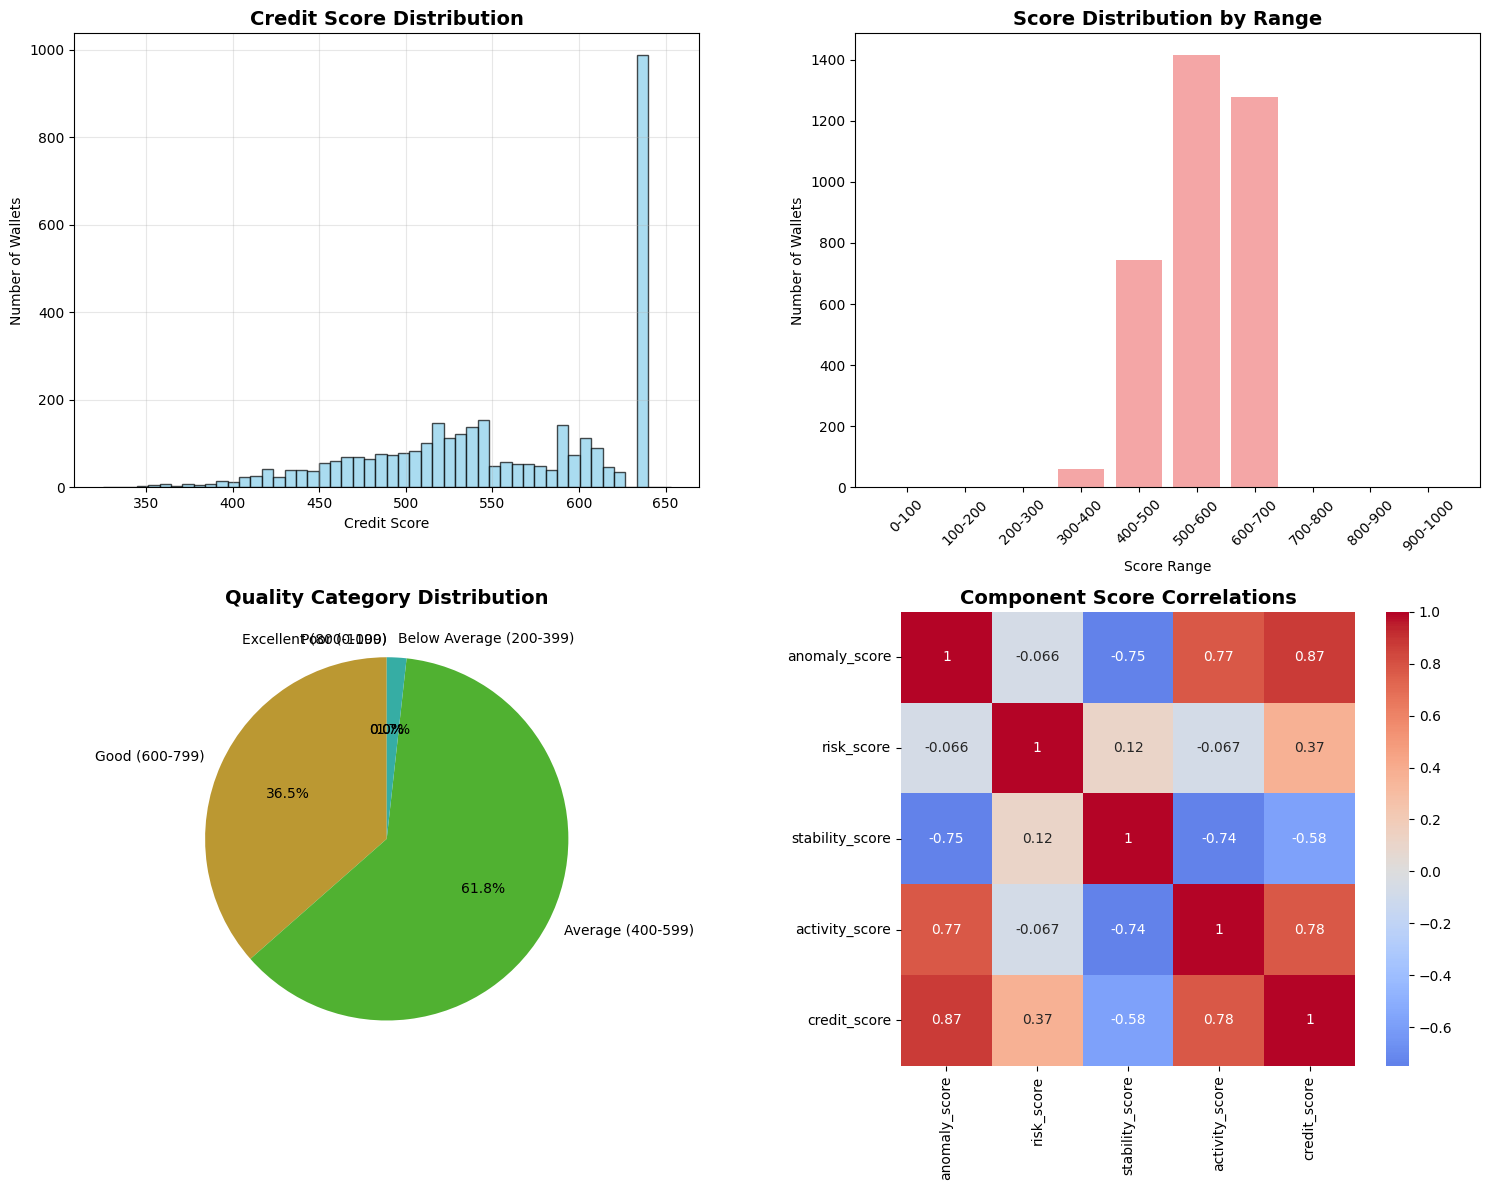


=== WALLET BEHAVIOR ANALYSIS BY SCORE RANGE ===

4. BEHAVIORAL METRICS BY SCORE RANGE:

TOTAL_TXNS:
                        mean  median      std
score_range                                  
Poor (0-199)             NaN     NaN      NaN
Below Avg (200-399)   374.52    28.0  1823.26
Average (400-599)      34.19     8.0    74.63
Good (600-799)          2.59     1.0     7.39
Excellent (800-1000)     NaN     NaN      NaN

DAYS_ACTIVE:
                       mean  median    std
score_range                               
Poor (0-199)            NaN     NaN    NaN
Below Avg (200-399)   66.82    69.0  41.33
Average (400-599)     33.08    18.0  36.19
Good (600-799)         3.50     1.0  10.16
Excellent (800-1000)    NaN     NaN    NaN

TXNS_PER_DAY:
                      mean  median    std
score_range                              
Poor (0-199)           NaN     NaN    NaN
Below Avg (200-399)   8.17     0.7  29.17
Average (400-599)     1.80     1.0   2.51
Good (600-799)        0.98     1.0   

C:\Users\nikk6\AppData\Local\Temp\ipykernel_28168\1185981222.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metric_by_range = analysis_df.groupby('score_range')[metric].agg(['mean', 'median', 'std']).round(2)
C:\Users\nikk6\AppData\Local\Temp\ipykernel_28168\1185981222.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metric_by_range = analysis_df.groupby('score_range')[metric].agg(['mean', 'median', 'std']).round(2)
C:\Users\nikk6\AppData\Local\Temp\ipykernel_28168\1185981222.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

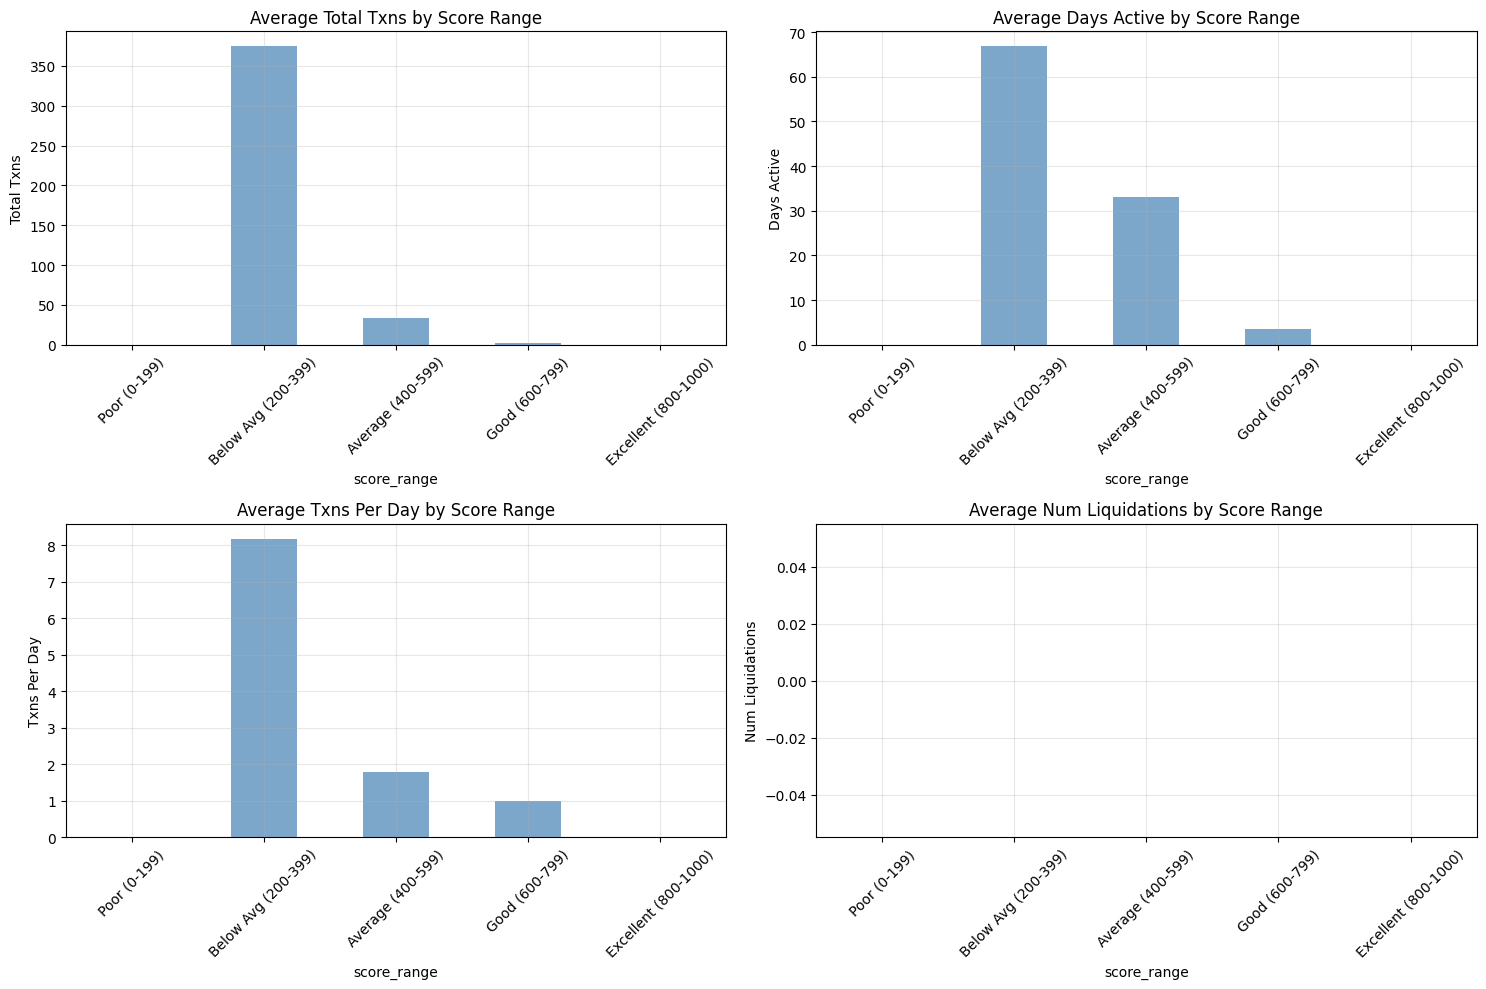


=== CLUSTER ANALYSIS ===

7. CLUSTER CHARACTERISTICS:
           credit_score                        anomaly_score risk_score  \
                  count    mean  median    std          mean       mean   
cluster_id                                                                
0                  1066  507.11  514.49  55.92         54.10      76.21   
1                  1752  601.88  633.50  48.11         90.13      74.25   
2                   320  475.73  478.43  49.09         46.47      73.96   
3                     1  363.46  363.46    NaN          0.00      75.00   
4                   358  532.12  540.38  44.54         65.71      74.61   

           stability_score activity_score  
                      mean           mean  
cluster_id                                 
0                    19.44           2.88  
1                     4.83          29.43  
2                    17.80           1.40  
3                    19.23           0.00  
4                     7.65          

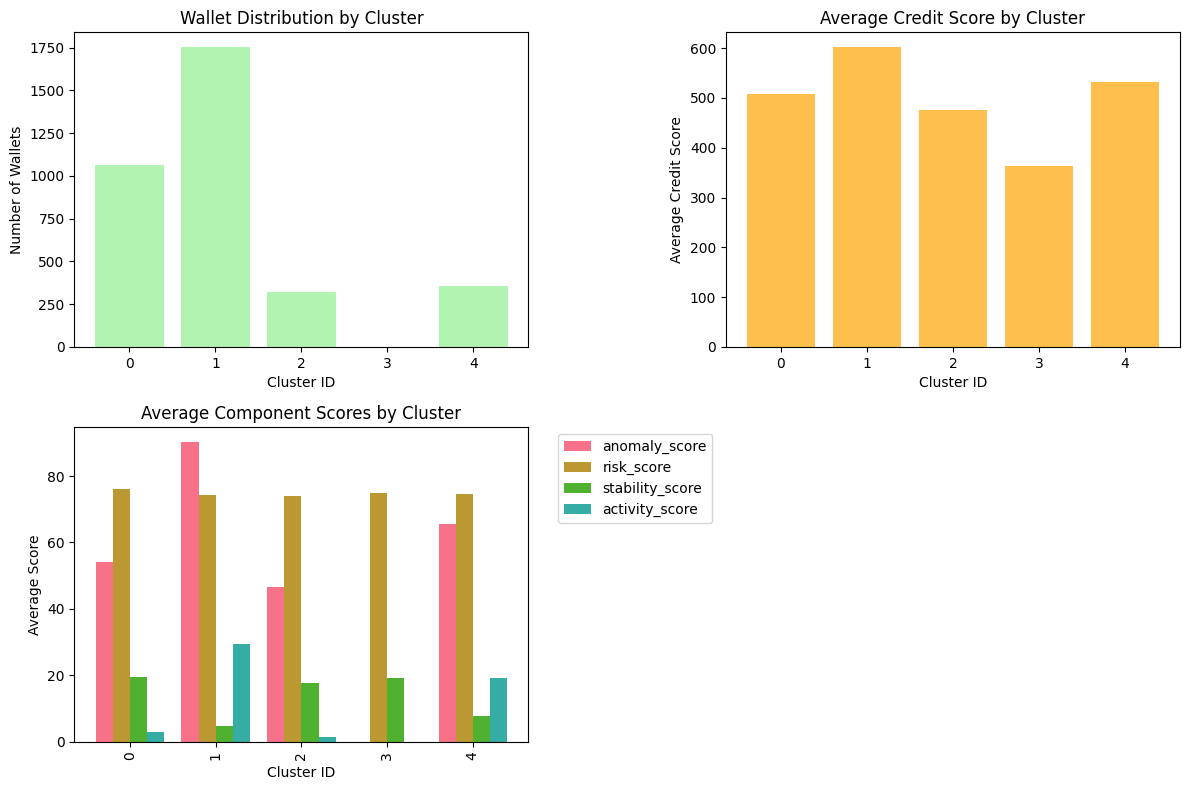


=== ANALYSIS COMPLETE ===
Use the results above to populate the analysis.md file


In [54]:
# Analysis Code for Credit Scores - Run this before creating analysis.md

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def analyze_score_distribution(credit_scores, wallet_features):
    """
    Comprehensive analysis of credit score distribution and wallet behavior
    """
    print("=== CREDIT SCORE DISTRIBUTION ANALYSIS ===\n")
    
    # Basic statistics
    print("1. OVERALL SCORE STATISTICS:")
    print(f"Total Wallets Analyzed: {len(credit_scores):,}")
    print(f"Mean Score: {credit_scores['credit_score'].mean():.2f}")
    print(f"Median Score: {credit_scores['credit_score'].median():.2f}")
    print(f"Standard Deviation: {credit_scores['credit_score'].std():.2f}")
    print(f"Min Score: {credit_scores['credit_score'].min():.2f}")
    print(f"Max Score: {credit_scores['credit_score'].max():.2f}")
    print()
    
    # Score range distribution
    print("2. SCORE RANGE DISTRIBUTION:")
    ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), 
              (500, 600), (600, 700), (700, 800), (800, 900), (900, 1000)]
    
    range_stats = []
    for low, high in ranges:
        count = len(credit_scores[(credit_scores['credit_score'] >= low) & 
                                 (credit_scores['credit_score'] < high)])
        percentage = (count / len(credit_scores)) * 100
        range_stats.append({
            'Range': f"{low}-{high}",
            'Count': count,
            'Percentage': percentage
        })
        print(f"  {low:3d}-{high:3d}: {count:6,} wallets ({percentage:5.1f}%)")
    
    print()
    
    # Quality categories
    print("3. QUALITY CATEGORY DISTRIBUTION:")
    categories = {
        'Excellent (800-1000)': len(credit_scores[credit_scores['credit_score'] >= 800]),
        'Good (600-799)': len(credit_scores[(credit_scores['credit_score'] >= 600) & 
                                           (credit_scores['credit_score'] < 800)]),
        'Average (400-599)': len(credit_scores[(credit_scores['credit_score'] >= 400) & 
                                              (credit_scores['credit_score'] < 600)]),
        'Below Average (200-399)': len(credit_scores[(credit_scores['credit_score'] >= 200) & 
                                                    (credit_scores['credit_score'] < 400)]),
        'Poor (0-199)': len(credit_scores[credit_scores['credit_score'] < 200])
    }
    
    for category, count in categories.items():
        percentage = (count / len(credit_scores)) * 100
        print(f"  {category}: {count:6,} wallets ({percentage:5.1f}%)")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Score distribution histogram
    axes[0, 0].hist(credit_scores['credit_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Credit Score Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Credit Score')
    axes[0, 0].set_ylabel('Number of Wallets')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Score range distribution
    range_df = pd.DataFrame(range_stats)
    axes[0, 1].bar(range_df['Range'], range_df['Count'], color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Score Distribution by Range', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Score Range')
    axes[0, 1].set_ylabel('Number of Wallets')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Quality category pie chart
    category_counts = list(categories.values())
    category_labels = list(categories.keys())
    axes[1, 0].pie(category_counts, labels=category_labels, autopct='%1.1f%%', startangle=90)
    axes[1, 0].set_title('Quality Category Distribution', fontsize=14, fontweight='bold')
    
    # 4. Component score correlation
    component_cols = ['anomaly_score', 'risk_score', 'stability_score', 'activity_score']
    if all(col in credit_scores.columns for col in component_cols):
        correlation_matrix = credit_scores[component_cols + ['credit_score']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                   ax=axes[1, 1], square=True)
        axes[1, 1].set_title('Component Score Correlations', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return range_stats, categories

def analyze_wallet_behavior_by_score(credit_scores, wallet_features):
    """
    Analyze wallet behavior patterns by score ranges
    """
    print("\n=== WALLET BEHAVIOR ANALYSIS BY SCORE RANGE ===\n")
    
    # Merge credit scores with wallet features
    analysis_df = wallet_features.merge(credit_scores[['userWallet', 'credit_score']], 
                                       on='userWallet', how='inner')
    
    # Define score ranges for analysis
    analysis_df['score_range'] = pd.cut(analysis_df['credit_score'], 
                                       bins=[0, 200, 400, 600, 800, 1000],
                                       labels=['Poor (0-199)', 'Below Avg (200-399)', 
                                              'Average (400-599)', 'Good (600-799)', 
                                              'Excellent (800-1000)'])
    
    # Analyze key behavioral metrics by score range
    behavioral_metrics = ['total_txns', 'days_active', 'txns_per_day', 'num_liquidations', 
                         'liq_ratio', 'repay_freq', 'account_age_days', 'unique_assets']
    
    # Filter to only existing columns
    existing_metrics = [col for col in behavioral_metrics if col in analysis_df.columns]
    
    print("4. BEHAVIORAL METRICS BY SCORE RANGE:")
    for metric in existing_metrics:
        print(f"\n{metric.upper()}:")
        metric_by_range = analysis_df.groupby('score_range')[metric].agg(['mean', 'median', 'std']).round(2)
        print(metric_by_range)
    
    # High-scoring wallet characteristics
    print("\n5. HIGH-SCORING WALLET CHARACTERISTICS (800-1000):")
    high_score_wallets = analysis_df[analysis_df['credit_score'] >= 800]
    if len(high_score_wallets) > 0:
        print(f"  Number of high-scoring wallets: {len(high_score_wallets)}")
        print(f"  Average total transactions: {high_score_wallets['total_txns'].mean():.1f}")
        if 'account_age_days' in high_score_wallets.columns:
            print(f"  Average account age: {high_score_wallets['account_age_days'].mean():.1f} days")
        if 'unique_assets' in high_score_wallets.columns:
            print(f"  Average unique assets: {high_score_wallets['unique_assets'].mean():.1f}")
        if 'liq_ratio' in high_score_wallets.columns:
            print(f"  Average liquidation ratio: {high_score_wallets['liq_ratio'].mean():.4f}")
    else:
        print("  No wallets found in this range")
    
    # Low-scoring wallet characteristics
    print("\n6. LOW-SCORING WALLET CHARACTERISTICS (0-199):")
    low_score_wallets = analysis_df[analysis_df['credit_score'] < 200]
    if len(low_score_wallets) > 0:
        print(f"  Number of low-scoring wallets: {len(low_score_wallets)}")
        print(f"  Average total transactions: {low_score_wallets['total_txns'].mean():.1f}")
        if 'account_age_days' in low_score_wallets.columns:
            print(f"  Average account age: {low_score_wallets['account_age_days'].mean():.1f} days")
        if 'unique_assets' in low_score_wallets.columns:
            print(f"  Average unique assets: {low_score_wallets['unique_assets'].mean():.1f}")
        if 'liq_ratio' in low_score_wallets.columns:
            print(f"  Average liquidation ratio: {low_score_wallets['liq_ratio'].mean():.4f}")
    else:
        print("  No wallets found in this range")
    
    # Create behavioral comparison visualization
    if len(existing_metrics) >= 4:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, metric in enumerate(existing_metrics[:4]):
            if i < 4:
                metric_data = analysis_df.groupby('score_range')[metric].mean()
                metric_data.plot(kind='bar', ax=axes[i], color='steelblue', alpha=0.7)
                axes[i].set_title(f'Average {metric.replace("_", " ").title()} by Score Range')
                axes[i].set_ylabel(metric.replace("_", " ").title())
                axes[i].tick_params(axis='x', rotation=45)
                axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return analysis_df

def generate_cluster_analysis(credit_scores):
    """
    Analyze cluster characteristics
    """
    print("\n=== CLUSTER ANALYSIS ===\n")
    
    if 'cluster_id' in credit_scores.columns:
        print("7. CLUSTER CHARACTERISTICS:")
        cluster_stats = credit_scores.groupby('cluster_id').agg({
            'credit_score': ['count', 'mean', 'median', 'std'],
            'anomaly_score': 'mean',
            'risk_score': 'mean',
            'stability_score': 'mean',
            'activity_score': 'mean'
        }).round(2)
        
        print(cluster_stats)
        
        # Visualize clusters
        plt.figure(figsize=(12, 8))
        
        # Cluster distribution
        plt.subplot(2, 2, 1)
        cluster_counts = credit_scores['cluster_id'].value_counts().sort_index()
        plt.bar(cluster_counts.index, cluster_counts.values, color='lightgreen', alpha=0.7)
        plt.title('Wallet Distribution by Cluster')
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Wallets')
        
        # Average scores by cluster
        plt.subplot(2, 2, 2)
        cluster_means = credit_scores.groupby('cluster_id')['credit_score'].mean()
        plt.bar(cluster_means.index, cluster_means.values, color='orange', alpha=0.7)
        plt.title('Average Credit Score by Cluster')
        plt.xlabel('Cluster ID')
        plt.ylabel('Average Credit Score')
        
        # Component scores by cluster
        plt.subplot(2, 2, 3)
        component_cols = ['anomaly_score', 'risk_score', 'stability_score', 'activity_score']
        existing_components = [col for col in component_cols if col in credit_scores.columns]
        
        if existing_components:
            cluster_components = credit_scores.groupby('cluster_id')[existing_components].mean()
            cluster_components.plot(kind='bar', ax=plt.gca(), width=0.8)
            plt.title('Average Component Scores by Cluster')
            plt.xlabel('Cluster ID')
            plt.ylabel('Average Score')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    else:
        print("Cluster information not available in the dataset")

# Run the analysis
print("Running comprehensive credit score analysis...")
range_stats, categories = analyze_score_distribution(credit_scores, wallet_features)
analysis_df = analyze_wallet_behavior_by_score(credit_scores, wallet_features)
generate_cluster_analysis(credit_scores)

print("\n=== ANALYSIS COMPLETE ===")
print("Use the results above to populate the analysis.md file")